<a href="https://colab.research.google.com/github/thwlruss10/VDA_pipeline/blob/main/BERT_DEIT_inference_20APR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers datasets nltk scikit-learn

In [3]:
import torch
import torch.nn as nn
from transformers import AutoModel
from typing import Optional

'''
The MultimodalVQAModel takes a question and an image as input.
It uses pre-trained models to extract features from both, combines these features,
and then predicts the answer to the question based on the combined information.
This architecture is typical for VQA tasks, where the goal is to understand both
visual and textual information to provide accurate answers.

forward() Defines how the model processes data during training and inference.
  input_ids: Tokenized representation of the question.
  pixel_values: Processed image data.
  attention_mask: Indicates which tokens in the question are relevant.
  token_type_ids: Distinguishes between different segments of text (if applicable).
  labels: The correct answer (used during training).
'''

class MultimodalVQAModel(nn.Module):  #Defining Mu-Mo-VQA model is per PyTorch base class nn.Module
    def __init__(
        self,
        pretrained_text_name: str,
        pretrained_image_name: str,
        num_labels: int,
        intermediate_dim: int = 512,  # increase to reduce overfitting can modify to 1024
        dropout: float = 0.5          # prevents overfitting, can decrease to 0.1.
    ):
        super(MultimodalVQAModel, self).__init__()

        self.num_labels = num_labels  #length of answer space
        self.text_encoder = AutoModel.from_pretrained(pretrained_text_name) # attention mechanism lives in pre-trained transformers
        self.image_encoder = AutoModel.from_pretrained(pretrained_image_name)

        # Fallback if pooler_output doesn't exist (e.g., in ViT)
        self.use_pooler_text = hasattr(self.text_encoder.config, "pooler_fc_size")
        self.use_pooler_image = hasattr(self.image_encoder.config, "pooler_fc_size")

        # Fusion + Classification layers
        # linear transformation, activation function (ReLU), dropout regularization
        # Integrates the combined features comprehensive representation
        self.fusion = nn.Sequential(
            nn.Linear(
                self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size,
                intermediate_dim
            ),
            # nn.BatchNorm1d(intermediate_dim),  # Add Batch Normalization
            nn.ReLU(),            # alt nn.LeakyReLU, nn.GELU, or nn.ELU
            nn.Dropout(dropout),
        )

        self.classifier = nn.Linear(intermediate_dim, self.num_labels)
        self.criterion = nn.CrossEntropyLoss()
    # Feed forward fusion
    def forward(
        self,
        input_ids: torch.LongTensor,
        pixel_values: torch.FloatTensor,
        attention_mask: Optional[torch.LongTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        labels: Optional[torch.LongTensor] = None
    ):
        # Encode text
        text_output = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        if "pooler_output" in text_output:          # not all pre-trained models have pooling, BERT has
            text_feat = text_output.pooler_output   # model to handle different pre-trained encoders by checking
        else:
            text_feat = text_output.last_hidden_state[:, 0]  # CLS token fallback

        # Encode image
        image_output = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        if "pooler_output" in image_output:
            image_feat = image_output.pooler_output
        else:
            image_feat = image_output.last_hidden_state[:, 0]  # CLS token fallback

        # Fuse + classify
        fused = self.fusion(torch.cat([text_feat, image_feat], dim=1))
        logits = self.classifier(fused)

        output = {"logits": logits}
        if labels is not None:
            output["loss"] = self.criterion(logits, labels)

        return output # Returns logit values associated with each label


In [ ]:
import torch

# Assign device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load config
config = torch.load("/content/drive/MyDrive/FinalProject/myenv/Demo-VQA_Bert-DEiT_config.pt")

# Reconstruct model
model = MultimodalVQAModel(**config)

In [ ]:
# Load the saved model weights
model.load_state_dict(torch.load("/content/drive/MyDrive/FinalProject/myenv/MM-VQA-demo20apr.pt"))

# Set the model to evaluation mode
model.eval()


In [ ]:
from transformers import AutoTokenizer, AutoImageProcessor

# Load the tokenizer and image processor
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
image_processor = AutoImageProcessor.from_pretrained("facebook/deit-base-patch16-224")


In [ ]:
'''
from transformers import ViltForQuestionAnswering, ViltProcessor

model = ViltForQuestionAnswering.from_pretrained("/content/drive/MyDrive/FinalProject/vilt_checkpoint")
processor = ViltProcessor.from_pretrained("/content/drive/MyDrive/FinalProject/vilt_checkpoint")
'''


In [8]:
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split

# Define base directory pointing to your Drive location
base_dir = "/content/drive/MyDrive/FinalProject/dataset"
os.makedirs(base_dir, exist_ok=True)

# Define regex to extract image ID
image_pattern = re.compile(r"( (in |on |of )?(the |this )?(image\d*) \?)")

# Read the raw Q&A file
# Extracts image ID and question at index[i] together with answer at [i+1]
# and organizes it into a pandas DataFrame, creates a list of unique answers,
# and then splits the dataset into training and testing sets, saving them as
# CSV.

qa_file = os.path.join(base_dir, "all_qa_pairs.txt")
with open(qa_file, "r", encoding="utf-8") as f: # open in read mode with in utf-8 encoding
    qa_data = [x.strip() for x in f.readlines()] # x.strip() removes white spaces

records = []
for i in range(0, len(qa_data), 2): # iterates in steps of two because quesiton is at index i and answer at i+1
    match = image_pattern.findall(qa_data[i]) # extract image ID from question string
    if match:
        img_id = match[0][3]
        question = qa_data[i].replace(match[0][0], "").strip() # remove image ID and replace question
        answer = qa_data[i + 1].strip() # answer retrieved from next element
        records.append({"question": question, "answer": answer, "image_id": img_id}) #populate dictionary



df = pd.DataFrame(records)


answer_space = []
for ans in df["answer"].to_list():
    if "," in ans:
        answer_space += ans.replace(" ", "").split(",")
    else:
        answer_space.append(ans)

# sort and remove duplicates from answer_space
answer_space = sorted(set(answer_space))

# Write the answer space to file
with open(os.path.join(base_dir, "answer_space.txt"), "w", encoding="utf-8") as f:
    f.writelines("\n".join(answer_space))

# Split dataset into training and evaluation
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Save to CSV
train_df.to_csv(os.path.join(base_dir, "data_train.csv"), index=False)
test_df.to_csv(os.path.join(base_dir, "data_eval.csv"), index=False)


In [9]:
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import re
import pandas as pd
import os
from transformers import (
    # Preprocessing / Common
    AutoTokenizer, AutoFeatureExtractor,
    # Text & Image Models & transformers (ViTModel, DeiTModel, BEiT)
    AutoModel,
    # Training / Evaluation
    TrainingArguments, Trainer,
    # Misc
    logging
)

# import nltk
# nltk.download('wordnet')

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# SET CACHE FOR HUGGINGFACE TRANSFORMERS + DATASETS
os.environ['HF_HOME'] = os.path.join(".", "cache")
# SET ONLY 1 GPU DEVICE
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

#set_caching_enabled(True)>> this line deleted as 'datasets' no longer supports explicit cahce enabling
#set_caching_enabled(True)
logging.set_verbosity_error()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [10]:
from nltk.corpus import wordnet as wn

def wup_measure(pred, gt, threshold=0.9):
    pred_synsets = wn.synsets(pred)
    gt_synsets = wn.synsets(gt)

    if not pred_synsets or not gt_synsets:
        return 0.0

    max_score = max((s1.wup_similarity(s2) or 0) for s1 in pred_synsets for s2 in gt_synsets)
    return 1.0 if max_score >= threshold else max_score

In [11]:

from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset,
})


In [12]:
from transformers import AutoTokenizer, AutoImageProcessor

# Rebuild processors from original names
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
image_processor = AutoImageProcessor.from_pretrained("facebook/deit-base-patch16-224")


In [13]:
tokenizer.save_pretrained("/content/drive/MyDrive/FinalProject/myenv/tokenizer/")
image_processor.save_pretrained("/content/drive/MyDrive/FinalProject/myenv/image_processor/")


['/content/drive/MyDrive/FinalProject/myenv/image_processor/preprocessor_config.json']

In [14]:
from transformers import AutoTokenizer, AutoImageProcessor

# Load back
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/FinalProject/myenv/tokenizer/")
image_processor = AutoImageProcessor.from_pretrained("/content/drive/MyDrive/FinalProject/myenv/image_processor/")


In [15]:
# Set the correct image directory in Google Drive
image_dir = "/content/drive/MyDrive/FinalProject/dataset/images"

In [16]:
def showExample(train=True, id=None):
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]

    if id is None:
        id = np.random.randint(len(data))

    img_path = os.path.join(image_dir, data[id]["image_id"] + ".png")

    if not os.path.exists(img_path):
        print(f"⚠️ Image not found at: {img_path}")
        return

    label = answer_space.index(data[id]["answer"]) if data[id]["answer"] in answer_space else "N/A"

    # Load question and image
    question = data[id]["question"]
    image = Image.open(img_path).convert("RGB")

    # 🔠 Tokenize question
    text_inputs = tokenizer(question, return_tensors="pt", padding=True, truncation=True)

    # 🖼️ Process image
    image_inputs = image_processor(images=image, return_tensors="pt")

    # 🧩 Merge inputs
    inputs = {
        "input_ids": text_inputs["input_ids"],
        "attention_mask": text_inputs["attention_mask"],
        "pixel_values": image_inputs["pixel_values"]
    }

    # 🔮 Run model
    with torch.no_grad():
        outputs = model(**inputs)

    # 📈 Predict
    logits = outputs["logits"]  # fixed: dictionary-style access
    predicted_idx = logits.argmax(-1).item()
    predicted_answer = answer_space[predicted_idx]
    wup_score = wup_measure(pred=predicted_answer, gt=data[id]["answer"])

    # 🎨 Display result
    print(f"✅ Found image at: {os.path.abspath(img_path)}")
    display(image)
    print("Question:\t", question)
    label = data[id].get("label", "N/A")  # fallback if key is missing
    #print("Answer:\t\t", data[id]["answer"], f"(Label: {label})")
    print("Answer:\t\t", data[id]["answer"])
    print("Predicted answer:", predicted_answer)
    print("WUP Score:", wup_score)


✅ Found image at: /content/drive/MyDrive/FinalProject/dataset/images/image1029.png


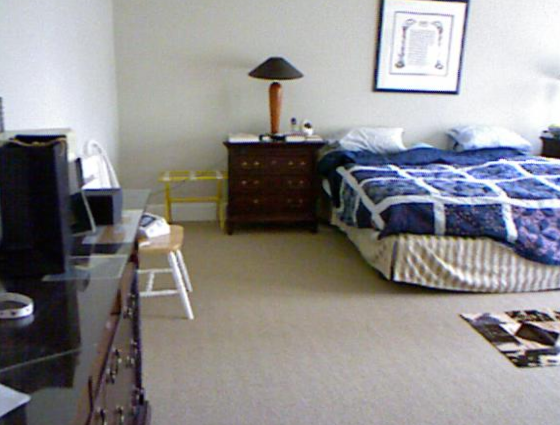

Question:	 what is spread on the bed
Answer:		 bed_sheets
Predicted answer: pillow
WUP Score: 0.5263157894736842


In [ ]:
showExample()